In [4]:
import requests
import csv
import re
import time
from collections import Counter

HOST = 'https://api.vk.com/method/'
VERSION = '5.103'
token = 'b998c97d3f2a83219c1279c5ee3deb93b2dfb82925dd2d1c781fd68ce7f4d3a00d0dae3ebe0865916f43c'


def get_users_from_google_table():
    with open('/home/nikita/Downloads/Контакты стримеров Twitch - Sheet1.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        ids = [re.sub(r'https://vk\.com/id', '', raw[4]) for raw in csv_reader]
               #if raw[4].startswith('https://vk\.com/id')]
            
    return ids


def get_members_of_favs():
    r = requests.get(HOST + 'groups.getMembers', params={'group_id': 'favs.tech',
                                                         'access_token': token,
                                                         'v': VERSION})
    if 'response' in r.json():
        return r.json()['response']['items']
    return []


def get_group_ids(user_ids):
    """ достаем id групп для каждого пользователя
        затем конкатенируем все группы
    """
    ids = []
    for user_id in user_ids:
        r = requests.get(HOST + 'groups.get', params={'user_id': user_id,
                                                      'access_token': token,
                                                      'v': VERSION})
        if 'response' in r.json():
            ids.extend(r.json()['response']['items'])
    return ids

def from_name_to_id(users):
    for i in range(len(users)):
        if not re.fullmatch('\d+', str(users[i])):
            r = requests.get(HOST + 'users.get', params={'user_ids': users[i],
                                                      'access_token': token,
                                                      'v': VERSION})
            if 'response' in r.json():
                users[i] = r.json()['response'][0]['id']

    return users            

In [5]:
%%time
google_users = get_users_from_google_table()
favs_users = get_members_of_favs()
# for i in range(len(google_users)):
#     if (re.search(r'https://vk\.com/public\d+', google_users[i])
#     or re.search(r'https://vk\.com/club\d+', google_users[i])):
#         google_users.remove(google_users[i])
user_ids = list(set(google_users) | set(favs_users))

CPU times: user 17.9 ms, sys: 7.95 ms, total: 25.8 ms
Wall time: 507 ms


In [ ]:
%%time
from_name_to_id(user_ids)

KeyboardInterrupt: 

In [57]:
%%time
start = time.time()
groups = get_group_ids(user_ids)
print(len(groups))
print(groups[:10])
print(time.time() - start)

178956
[127217221, 133030665, 43776215, 90983046, 152029585, 40836944, 28905875, 141514192, 187985290, 71729358]
528.9917364120483
CPU times: user 23.4 s, sys: 942 ms, total: 24.3 s
Wall time: 8min 48s


In [88]:
top_10_groups = Counter(groups).most_common(20)
print(top_10_groups)

[(181154419, 489), (30602036, 158), (57846937, 140), (91050183, 139), (177772463, 130), (45745333, 121), (138011123, 110), (22822305, 104), (96042317, 100), (180468605, 98), (133730084, 95), (135209264, 94), (186822531, 94), (28905875, 93), (157731480, 93), (66678575, 91), (189390879, 91), (189621436, 91), (190794845, 91), (191049619, 91)]


In [87]:
for group in top_10_groups:
    r = requests.get(HOST + 'groups.getById', params={'group_ids': group[0], 'access_token': token,'v': VERSION,
                                                     'fields' : ['name', 'screen_name']})
    print(r.json()['response'][0]['name'], '-----', 'https://vk.com/' + r.json()['response'][0]['screen_name'])

FAVS. Профессиональное сообщество стримеров. ----- https://vk.com/favs.tech
IGM ----- https://vk.com/igm
MDK ----- https://vk.com/mudakoff
Леонардо Дай Винчик ----- https://vk.com/dayvinchik
WASD.TV ----- https://vk.com/wasd_tv
4ch inc. ----- https://vk.com/4ch
Fortnite ----- https://vk.com/fortnite
Команда ВКонтакте ----- https://vk.com/team
DonationAlerts ----- https://vk.com/donationalerts
TWITCH FAMILY ----- https://vk.com/twitch_family
Подбор Авто Москва ----- https://vk.com/podborauto_01
Бот Максим ----- https://vk.com/bot_maxim
Мастер и модель Кемерово ----- https://vk.com/moddelumassterkemerovo
Рифмы и Панчи ----- https://vk.com/rhymes
Ищу Фрилансера. СММ, Таргет, Дизайн, Работа ----- https://vk.com/ishysmm
Овсянка, сэр! ----- https://vk.com/ovsyanochan
Ремонт квартир в Москве и Московской области ----- https://vk.com/1remont11
Сдать - снять квартиру, студию, комнату в Москве ----- https://vk.com/arendavmoskve1
CS:GO (Честный розыгрыш) ----- https://vk.com/club190794845
Маски М

In [47]:
sex = []
country = []
city = []
age = []

str_users = [str(x) for x in user_ids if re.fullmatch(r'\d+', str(x))]

In [48]:
for user in str_users:
    r = requests.get(HOST + 'users.get', params={'user_ids': user,'access_token': token, 'v': VERSION,
                                                 'fields': "sex, city, country, bdate"})

    sex.append(r.json()['response'][0]['sex'])
    country.append(r.json()['response'][0]['country']['title'] if 'country' in r.json()['response'][0] else 0)  
    city.append(r.json()['response'][0]['city']['title'] if 'city' in r.json()['response'][0] else 0) 
    date = r.json()['response'][0]['bdate'].split('.') if 'bdate' in r.json()['response'][0] else ''
    if len(date) == 3:
        age.append(2020-int(date[2]))


In [44]:
# import sys
# sys.path.append('/home/nikita/PycharmProjects/promo_venv/lib/python3.6/site-packages')
# sys.path
from matplotlib import pyplot as plt 


(array([71., 50., 84., 63., 60., 10.,  5.,  5.,  0.,  2.,  2.,  0.,  0.,
         0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  2.,
         0.,  1.,  2.,  4.]),
 array([ 14.        ,  17.46666667,  20.93333333,  24.4       ,
         27.86666667,  31.33333333,  34.8       ,  38.26666667,
         41.73333333,  45.2       ,  48.66666667,  52.13333333,
         55.6       ,  59.06666667,  62.53333333,  66.        ,
         69.46666667,  72.93333333,  76.4       ,  79.86666667,
         83.33333333,  86.8       ,  90.26666667,  93.73333333,
         97.2       , 100.66666667, 104.13333333, 107.6       ,
        111.06666667, 114.53333333, 118.        ]),
 <a list of 30 Patch objects>)

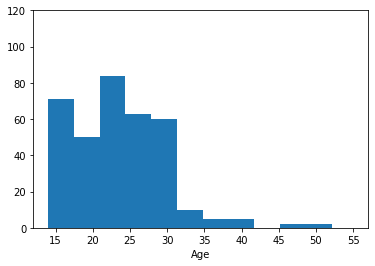

In [71]:
plt.axis([12, 57, 0, 120]) 
plt.xlabel('Age')
plt.hist(age, 3)

In [69]:
Counter(age).most_common(30)

[(25, 31),
 (20, 31),
 (15, 26),
 (16, 25),
 (21, 24),
 (22, 22),
 (24, 20),
 (28, 19),
 (26, 18),
 (29, 18),
 (23, 18),
 (27, 14),
 (17, 12),
 (31, 12),
 (30, 11),
 (18, 10),
 (19, 9),
 (14, 8),
 (33, 6),
 (32, 3),
 (39, 3),
 (118, 3),
 (35, 3),
 (52, 2),
 (104, 2),
 (48, 2),
 (75, 1),
 (38, 1),
 (67, 1),
 (114, 1)]